## Serological Shields - US States


### Contents:
1. [Documenting core model modified for US states](#Documenting-core-model-modified-for-US-states)
2. [Effects of state demography on epidemic spread](#Effects-of-demography-on-epidemic-spread)
    1. [Georgia COVID-19 dynamics](#Georgia-COVID-19-dynamics)
    2. [Analysis of serological shielding across states with fraction over 60 low R0](#Analysis-of-serological-shielding-across-states-with-fraction-over-60-low-R0)
    3. [State-by-state outcomes low R0](#State-by-state-outcomes-low-R0)
    4. [Analysis of serological shielding across states with fraction over 60 high R0](#Analysis-of-serological-shielding-across-states-with-fraction-over-60-high-R0)
    5. [State-by-state outcomes high R0](#State-by-state-outcomes-high-R0)

## Documenting core model modified for US states<a id="core"></a>

Here, we use an age-structured epidemiological model to investigate how age-structured decision making may influence disease dynamics. State level data is aggregated from year 0 to 85+. As such we modify the core model to incorporates 9 age classes (0-9 years old, 10-19 years old, ... 70-80 years old, 80+ years old); and 8 epidemiological states.

The population who have not encountered the disease can be in a susceptible ($S$) class where there is the potential of being infected. Upon being exposed ($E$), the disease progresses either asymptomatically ($I_{asym}$) or symptomatically ($I_{sym}$). Of those who display symptoms, some will recover alone, but others will require sub-critical ($I_{h,sub}$) or critical (ICU beds required) ($I_{h,crit}$) hospital care. Of those in critical condition some will be killed by the disease ($D$). Those who do not die from the disease recover ($R$) with immunity to the disease. If recovered individuals can be identified they can take up key positions requiring face-to-face interactions, without further spreading the disease. They will not be able to catch the disease from infected individuals, and will not be able to transmit the disease to the susceptible population. Therefore, it is beneficial for people to interact with those who are serologically shown to have recovered from COVID-19 and who are no longer shedding viruses. In this way identified recovered individuals can act as "serological shields" through becoming preferential contacts for those who have not been tested.

In [1]:
#load package dependencies
using Plots, DifferentialEquations, LaTeXStrings, StatsPlots, CSV, Pkg
#show package versions
Pkg.status()

    Status `C:\Users\Steve\.julia\environments\v1.3\Project.toml`
  [336ed68f] CSV v0.5.26
  [a93c6f00] DataFrames v0.20.2
  [aae7a2af] DiffEqFlux v1.3.2
  [0c46a032] DifferentialEquations v6.10.1
  [587475ba] Flux v0.10.1
  [7073ff75] IJulia v1.21.1
  [c601a237] Interact v0.10.3
  [b964fa9f] LaTeXStrings v1.1.0
  [47be7bcc] ORCA v0.3.1
  [429524aa] Optim v0.20.1
  [f0f68f2c] PlotlyJS v0.13.1
  [91a5bcdd] Plots v0.28.4
  [d330b81b] PyPlot v2.8.2
  [6f49c342] RCall v0.13.4
  [90137ffa] StaticArrays v0.12.1
  [f3b207a7] StatsPlots v0.14.2
  [fd094767] Suppressor v0.1.1
  [0f1e0344] WebIO v0.8.13
  [fdbf4ff8] XLSX v0.6.0


In [2]:
#show julia version
VERSION

v"1.3.1"

First, we define a population age structure. Here, we define a population of 10,000,000 people with an age structure similar to that of the UK and the US. Let us contain the population demography in an object.

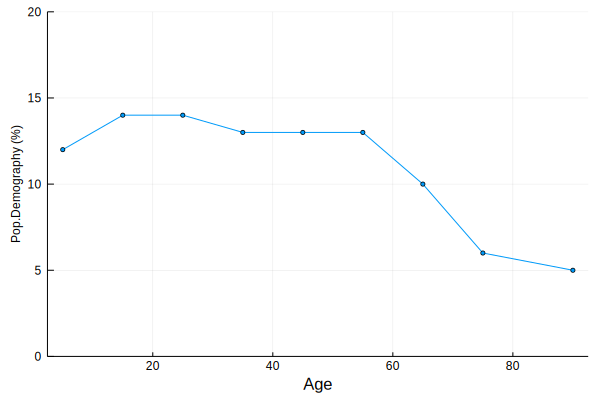

In [3]:
#Define population structure
struct POPDEMOG
    AgeStructure #fraction of population in each age class
    PopulationSize #number of people in population
end


ExamplePOP = POPDEMOG([0.12,0.14,0.14,0.13,0.13,0.13,0.10,0.06,0.05],10*10^6)

MinAge = [0,10,20,30,40,50,60,70,80]
MiddleAge = [5,15,25,35,45,55,65,75,90]

#Plot the population structure
plot(MiddleAge,ExamplePOP.AgeStructure*100.0,xlabel="Age",ylims=(0,20),ylabel = "Pop.Demography (%)",legend = false,yguidefontsize=8,markershape = :auto,markersize=2)

We define the number of states in the model; and the indices that will refer to these states.

In [4]:
#Define state indexes
NumAgeClasses = 9; #0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+
NumEpiStates = 8; # S,E,Ia,Is,Ihsub,Ihcrit,R,D

#Indexing
S_ind = 1:NumAgeClasses
E_ind = (1*NumAgeClasses+1):2*NumAgeClasses
Ia_ind = (2*NumAgeClasses+1):3*NumAgeClasses
Is_ind = (3*NumAgeClasses+1):4*NumAgeClasses
Ihsub_ind = (4*NumAgeClasses+1):5*NumAgeClasses
Ihcrit_ind = (5*NumAgeClasses+1):6*NumAgeClasses
R_ind = (6*NumAgeClasses+1):7*NumAgeClasses
D_ind = (7*NumAgeClasses+1):8*NumAgeClasses

64:72

The system of nonlinear differential equations governing this age-structured epidemiological are as follows:

\begin{align}
\frac{dS(a)}{dt} & =  -\overset{new\ cases\ from\ symptomatic\ contact}{\overbrace{\frac{\beta_S S(a) I_{sym,Tot}}{N_{Tot} + \alpha R_{Shields}} }}  - \overset{new\ cases\ from\ asymptomatic\ contact}{\overbrace{\frac{\beta_A S(a) I_{asym,Tot}}{N_{Tot} + \alpha R_{Shields}} }}  \\
\frac{dE(a)}{dt} & =  \overset{new\ cases\ from\ symptomatic\ contact}{\overbrace{ \frac{\beta_S S(a) I_{sym,Tot}}{N_{Tot} + \alpha R_{Shields}} }} + \overset{new\ cases\ from\ asymptomatic\ contact}{\overbrace{\frac{\beta_A S(a) I_{asym,Tot}}{N_{Tot} + \alpha R_{Shields}} }}  - \overset{onset\ of\ disease}{\overbrace{\gamma_E E(a)}} \\
\frac{dI_{asym}(a)}{dt} & =  \overset{asymptomatic\ onset}{\overbrace{p(a)\gamma_E E(a)}} - \overset{recovery}{\overbrace{\gamma_A I_{asym}(a)}} \\
\frac{dI_{sym}(a)}{dt} & =  \overset{symptomatic\ onset}{\overbrace{(1-p(a))\gamma_E E(a)}} - \overset{transfer\ from\ I_{sym}}{\overbrace{\gamma_S I_{sym}(a)}} \\
\frac{dI_{h,sub}(a)}{dt} & =  \overset{subcritical\ cases}{\overbrace{h(a)(1-\xi(a)) \gamma_S I_{sym}(a)}} - \overset{transfer\ from\ I_{h,sub}}{\overbrace{\gamma_h I_{h,sub}(a)}} \\
\frac{dI_{h,crit}(a)}{dt} & =  \overset{critical\ (ICU)\ cases}{\overbrace{h(a)\xi(a) \gamma_S I_{sym}(a)}} - \overset{transfer\ from\ I_{h,crit}}{\overbrace{\gamma_h I_{h,crit}(a)}} \\
\frac{dR(a)}{dt} & =  \overset{recovery\ from\ I_{asym}}{\overbrace{\gamma_A I_{asym}(a)}} - \overset{recovery\ from\ I_{sym}}{\overbrace{(1-h(a))\gamma_S I_{sym}(a)}} - \overset{recovery\ from\ I_{h,sub}}{\overbrace{\gamma_h I_{h,sub}(a)}} - \overset{recovery\ from\ I_{h,crit}}{\overbrace{(1-\mu)\gamma_h I_{h,crit}(a)}} \\
\frac{dD(a)}{dt} & = \overset{mortality}{\overbrace{\mu \gamma_h I_{h,crit}(a)}}
\end{align}

where $I_{sym,Tot}$ are the total number (across all age classes) of sympomatic infectious individuals, $I_{asym,Tot}$ are the total number of asymptomatic infectious individuals, $N_{Tot}$ is the total number of alive individuals (not in the $D$ state), and $R_{Shields}$ are the number of recovered individuals who could serve as serological shields - which we define as those of ages between 20 and 59. 

In [5]:
#code for the system of differential equations
function SerologicalShieldsStates!(du,u,par,t)
    β_a,β_s,p,γ_e,γ_a,γ_s,γ_h,h,ξ,μ,α,S_ind,E_ind,Ia_ind,Is_ind,Ihsub_ind,Ihcrit_ind,R_ind,D_ind = par
    
    TOTI_a = sum(u[Ia_ind]) #Total asymptomatic infectious individuals
    TOTI_s = sum(u[Is_ind]) #Total symptomatic infectious individuals

    ShieldRTOT = sum(u[R_ind[3:6]]) #Total serological shields - those who are recovered and 20-60 yo.
    NTOT = sum(u[1:63]) #All individuals not in the dead (D) state
    SHIELD = ShieldRTOT
    
    for aa = 1:length(S_ind)#for each age class
        INDS = [S_ind[aa],E_ind[aa],Ia_ind[aa],Is_ind[aa],Ihsub_ind[aa],Ihcrit_ind[aa],R_ind[aa],D_ind[aa]]
        S,E,Ia,Is,Ihsub,Ihcrit,R,D = u[INDS]
        du[INDS[1]] = -β_a*S*TOTI_a/(NTOT+α*SHIELD) - β_s*S*TOTI_s/(NTOT+α*SHIELD) #dS/dt
        du[INDS[2]] = β_a*S*TOTI_a/(NTOT+α*SHIELD) + β_s*S*TOTI_s/(NTOT+α*SHIELD) -  γ_e*E   #dE/dt
        du[INDS[3]] = p[aa]*γ_e*E - γ_a*Ia  #dI_a /dt
        du[INDS[4]] = (1-p[aa])*γ_e*E - γ_s*Is  #dI_s/dt
        du[INDS[5]] = h[aa]*(1-ξ[aa])*γ_s*Is - γ_h*Ihsub #dIhsub/dt
        du[INDS[6]] = h[aa]*ξ[aa]*γ_s*Is -  γ_h*Ihcrit #dIhcrit/dt
        du[INDS[7]] = γ_a*Ia + (1-h[aa])*γ_s*Is + γ_h*Ihsub + (1-μ[aa])*γ_h*Ihcrit  #dR/dt
        du[INDS[8]] = μ[aa]*γ_h*Ihcrit #dD/dt
    end
 
end

SerologicalShieldsStates! (generic function with 1 method)

The serological states model has 11 parameters: the tramission rate from symptomatic infectious individuals $\beta_S$, the tramission rate from asymptomatic infectious individuals $\beta_A$, the mean exposed period $\frac{1}{\gamma_E}$, the mean asymptomatic infected period $\frac{1}{\gamma_A}$, the mean symptomatic infected period $\frac{1}{\gamma_S}$, $p$ the proportion of cases that result in asymptomatic infection, $h$ the proportion of cases with symptoms needing a hospital visit, $\xi$ the proportion of hospitilised cases that require critical ICU care, the mean period of hospitalisation $\frac{1}{\gamma_h}$, $\mu$ the proportion of critical cases that die from the disease, and $\alpha$ the level of serological shielding.  $h$ and $\xi$ are age-structured parameters.

We model dynamics looking at a high and low level of transmission, and with three levels of serological shielding - either none, 2:1 or 20:1.

In [6]:
#Define model parameters

β_A = 0.4 #asymptomatic transmission (days-1)
β_S = 0.8 #symptomatic transmission (days-1)
γ_e = (1.0/4.0) #inverse mean exposed period (days-1)
#low R0 scenario
γ_al = (1.0/4.0) #inverse mean asymptomatic period (days-1)
γ_sl = (1.0/4.0) #inverse mean symptomatic period (days-1)
#High R0 scenario
γ_ah = (1.0/6.0) #inverse mean asymptomatic period (days-1)
γ_sh = (1.0/6.0) #inverse mean symptomatic period (days-1)

γ_h = (1.0/10.0) #inverse mean hospitalised period (days-1)

#The below are modified to 9 age-classes
p = [0.95, 0.95,0.9,0.8,0.7,0.6,0.4,0.2,0.2]  #fraction of cases that are asymptomatic
h = [0.1, 0.3, 1.2, 3.2, 4.9, 10.2, 16.6, 24.3, 27.3]./100; #fraction of cases that require a hospital visit (by age class)
ξ = [5, 5, 5, 5, 6.3, 12.2, 27.4, 43.2, 70.9]./100; #fraction of hospitalised cases that become critical and require critical care (by age class)
μ = 0.5.*ones(NumAgeClasses) #mortality fraction


#levels of serological shielding
α0 = 0.0
α1 = 2.0
α2 = 20.0

#parameter sets

params0 = [β_A,β_S,p,γ_e,γ_al,γ_sl,γ_h,h,ξ,μ,α0,S_ind,E_ind,Ia_ind,Is_ind,Ihsub_ind,Ihcrit_ind,R_ind,D_ind]
params2 = [β_A,β_S,p,γ_e,γ_al,γ_sl,γ_h,h,ξ,μ,α1,S_ind,E_ind,Ia_ind,Is_ind,Ihsub_ind,Ihcrit_ind,R_ind,D_ind]
params20 = [β_A,β_S,p,γ_e,γ_al,γ_sl,γ_h,h,ξ,μ,α2,S_ind,E_ind,Ia_ind,Is_ind,Ihsub_ind,Ihcrit_ind,R_ind,D_ind]

params0h = [β_A,β_S,p,γ_e,γ_ah,γ_sh,γ_h,h,ξ,μ,α0,S_ind,E_ind,Ia_ind,Is_ind,Ihsub_ind,Ihcrit_ind,R_ind,D_ind]
params2h = [β_A,β_S,p,γ_e,γ_ah,γ_sh,γ_h,h,ξ,μ,α1,S_ind,E_ind,Ia_ind,Is_ind,Ihsub_ind,Ihcrit_ind,R_ind,D_ind]
params20h = [β_A,β_S,p,γ_e,γ_ah,γ_sh,γ_h,h,ξ,μ,α2,S_ind,E_ind,Ia_ind,Is_ind,Ihsub_ind,Ihcrit_ind,R_ind,D_ind]


19-element Array{Any,1}:
  0.4                                                                                                  
  0.8                                                                                                  
   [0.95, 0.95, 0.9, 0.8, 0.7, 0.6, 0.4, 0.2, 0.2]                                                     
  0.25                                                                                                 
  0.16666666666666666                                                                                  
  0.16666666666666666                                                                                  
  0.1                                                                                                  
   [0.001, 0.003, 0.012, 0.032, 0.049, 0.102, 0.166, 0.243, 0.273]                                     
   [0.05, 0.05, 0.05, 0.05, 0.063, 0.122, 0.27399999999999997, 0.43200000000000005, 0.7090000000000001]
   [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 

We now define the initial conditions for the model. We seed the outbreak with 1 case from the ages 20-29. This initial condition is used to spin-up the epidemic to 10,000 cases.

In [7]:
POP = ExamplePOP #assign population statistics
#seed population with 1 exposed case
uss0 = zeros(NumAgeClasses*NumEpiStates) #vector of initial states
uss0[S_ind] = POP.AgeStructure.*POP.PopulationSize #put everything in S
uss0[3] = uss0[3]-1 #remove infected from S ages 20-29
uss0[3+NumAgeClasses] = 1  #assign E cases ages 20-29
uss0 = uss0./POP.PopulationSize;  #renormalise

First, we will evaluate the low R0 outbreak. Now we define 3 scenarios (no, some and more serological shielding) as differential equation problems and solve them using numerical integration.

In [8]:
tspan = (0.0,400.0) #run the simulations between 0 days and 400 days

#initial spin-up
prob_init = ODEProblem(SerologicalShieldsStates!,uss0,tspan,params0)

#set up callback to stop integration when number of cases reaches a threshold
CaseThreshold = 10_000/POP.PopulationSize

condition(u,t,integrator)  = sum(u[1:NumAgeClasses]) - (1 - CaseThreshold)  #this must be equal to zero at stopping condition
affect!(integrator) = terminate!(integrator) 
cb = ContinuousCallback(condition,affect!)
#solve the initial spin up, checking for positivity and using callback definition 
sol_init = solve(prob_init,Tsit5(), abstol=1e-8,reltol=1e-8,saveat=1,isoutofdomain=(y,p,t)->any(x->x<0,y), callback = cb)

#assign end spinup states as new initial condition.
uInit = sol_init.u[end];

#run scenarios
prob_alph0 = ODEProblem(SerologicalShieldsStates!,uInit,tspan,params0)
prob_alph2 = ODEProblem(SerologicalShieldsStates!,uInit,tspan,params2)
prob_alph20 = ODEProblem(SerologicalShieldsStates!,uInit,tspan,params20)

sol_alph0 = solve(prob_alph0,Tsit5(), abstol=1e-8,reltol=1e-8,saveat=1,isoutofdomain=(y,p,t)->any(x->x<0,y))
sol_alph2 = solve(prob_alph2,Tsit5(), abstol=1e-8,reltol=1e-8,saveat=1,isoutofdomain=(y,p,t)->any(x->x<0,y))
sol_alph20 = solve(prob_alph20,Tsit5(), abstol=1e-8,reltol=1e-8,saveat=1,isoutofdomain=(y,p,t)->any(x->x<0,y));

and for the high R0 transmission outbreak scenarios

In [9]:
tspan = (0.0,400.0) #run the simulations between 0 days and 400 days

#initial spin-up
prob_init = ODEProblem(SerologicalShieldsStates!,uss0,tspan,params0h)

#set up callback to stop integration when number of cases reaches a threshold
CaseThreshold = 10_000/POP.PopulationSize

condition(u,t,integrator)  = sum(u[1:NumAgeClasses]) - (1 - CaseThreshold)  #this must be equal to zero at stopping condition
affect!(integrator) = terminate!(integrator) 
cb = ContinuousCallback(condition,affect!)
#solve the initial spin up, checking for positivity and using callback definition 
sol_init = solve(prob_init,Tsit5(), abstol=1e-8,reltol=1e-8,saveat=1,isoutofdomain=(y,p,t)->any(x->x<0,y), callback = cb)

#assign end spinup states as new initial condition.
uInit = sol_init.u[end];

#run scenarios
prob_alph0h = ODEProblem(SerologicalShieldsStates!,uInit,tspan,params0h)
prob_alph2h = ODEProblem(SerologicalShieldsStates!,uInit,tspan,params2h)
prob_alph20h = ODEProblem(SerologicalShieldsStates!,uInit,tspan,params20h)

sol_alph0h = solve(prob_alph0h,Tsit5(), abstol=1e-8,reltol=1e-8,saveat=1,isoutofdomain=(y,p,t)->any(x->x<0,y))
sol_alph2h = solve(prob_alph2h,Tsit5(), abstol=1e-8,reltol=1e-8,saveat=1,isoutofdomain=(y,p,t)->any(x->x<0,y))
sol_alph20h = solve(prob_alph20h,Tsit5(), abstol=1e-8,reltol=1e-8,saveat=1,isoutofdomain=(y,p,t)->any(x->x<0,y));

Now we define some functions to help plot the output.

In [10]:


#Define some additional functions to help with analysis

#Find Population-wide states from the solution to ODE
function PopWideStates_ss!(sol,par)
    β_a,β_s,p,γ_e,γ_a,γ_s,γ_h,h,ξ,μ,α,S_ind,E_ind,Ia_ind,Is_ind,Ihsub_ind,Ihcrit_ind,R_ind,D_ind = par
Sols =  hcat(sol.u...)
SS = zeros(length(sol.t))
EE = zeros(length(sol.t))
IA = zeros(length(sol.t))
IS = zeros(length(sol.t))
IHs = zeros(length(sol.t))
IHc = zeros(length(sol.t))
RR = zeros(length(sol.t))
DD =zeros(length(sol.t))
D_per_day = zeros(length(sol.t))
    NumAgeClasses=length(S_ind)
for aa=1:NumAgeClasses
    SS= SS+ Sols[S_ind[aa],:]
    EE= EE+ Sols[E_ind[aa],:]
    IA= IA+ Sols[Ia_ind[aa],:]
    IS= IS+ Sols[Is_ind[aa],:]
    IHs = IHs+ Sols[Ihsub_ind[aa],:]
    IHc = IHc+ Sols[Ihcrit_ind[aa],:]
    RR= RR+ Sols[R_ind[aa],:]
    DD= DD+ Sols[D_ind[aa],:]
    #D_per_day = D_per_day+ μ[aa].*γ_h.*Sols[Ihcrit_ind[aa],:].*1.0 #this is a rate of dead/day multiplied by time period of 1 day
    D_per_day = D_per_day + [(Sols[D_ind[aa],2:end] .- Sols[D_ind[aa],1:(end-1)]);  0]
end
    D_by_age = Sols[D_ind,end] #at end timepoint

    return SS,EE,IA,IS,IHs,IHc,RR,DD,D_per_day,D_by_age
end


#plotting function - plot deaths per day, ICU beds occupied and cumulative deaths by age group
function PlotResults!(sol,par,POP,MeanAge,title_plot,txtsize,SCALING)
    SS,EE,IA,IS,IHs,IHc,RR,DD,D_per_day,D_by_age = PopWideStates_ss!(sol,par);

    p1 = plot(sol.t,SCALING.*D_per_day,ylabel="Deaths per day",xlabel="Time (days)",legend = false,yguidefontsize=txtsize,title=title_plot)
    p2 = plot(sol.t,SCALING.*(IHc),ylabel="ICU bed req.",xlabel="Time (days)",legend=false,yguidefontsize=txtsize)
    #plot!(sol.t,SCALING.*(IHs+IHc),legend=false) #all hospitalised
    p3 = plot(MeanAge,SCALING.*D_by_age,xlabel="Age",ylabel="Cumulative deaths",legend=false,yguidefontsize=txtsize)
    #plt = twinx() #this helps do two axes on one plot, hard to make this look good right now.
    # plot!(plt,x,y,...) #same as previous line
    #p4 = plot(MeanAge,POP.frac_pop_by_age,xlabel="Age",ylabel = "Pop.Demography",legend = false,yguidefontsize=txtsize)
    return p1,p2,p3,DD
end




#plotting function - plot deaths per day, ICU beds occupied and cumulative deaths by age group
function PlotResults2!(sol1,sol2,sol3,par1,par2,par3,MiddleAge,title_plot,txtsize,SCALING)
    SS1,EE1,IA1,IS1,IHs1,IHc1,RR1,DD1,D_per_day1,D_by_age1 = PopWideStates_ss!(sol1,par1);
    SS2,EE2,IA2,IS2,IHs2,IHc2,RR2,DD2,D_per_day2,D_by_age2 = PopWideStates_ss!(sol2,par2);
    SS3,EE3,IA3,IS3,IHs3,IHc3,RR3,DD3,D_per_day3,D_by_age3 = PopWideStates_ss!(sol3,par3);

    MKS=2
    
    p1 = plot(sol1.t,SCALING.*D_per_day1,ylabel="Deaths per day \n per 100,000",xlabel="Time (days)",label = L"\alpha=0",
        foreground_color_legend = nothing,background_color_legend=nothing, yguidefontsize=txtsize,title=title_plot,legend=:topright)
    plot!(sol2.t,SCALING.*D_per_day2,label=L"\alpha=2")
    plot!(sol3.t,SCALING.*D_per_day3,label=L"\alpha=20")
    p2 = plot(sol1.t,SCALING.*(IHc1),ylabel="ICU bed demand \n per 100,000",xlabel="Time (days)",legend=false,yguidefontsize=txtsize)
    plot!(sol2.t,SCALING.*IHc2,legend=false)
    plot!(sol3.t,SCALING.*IHc3,legend=false)
    #plot!(sol.t,SCALING.*(IHs+IHc),legend=false) #all hospitalised
    p3 = plot(MiddleAge,SCALING.*D_by_age1,markershape = :auto,markersize=MKS,xlabel="Age",ylabel="Cumulative deaths \n per 100,000",legend=false,yguidefontsize=txtsize)
    plot!(MiddleAge,SCALING.*D_by_age2,legend=false,markershape = :auto,markersize=MKS)
    plot!(MiddleAge,SCALING.*D_by_age3,legend=false,markershape = :auto,markersize=MKS)
    
    #plt = twinx() #this helps do two axes on one plot, hard to make this look good right now.
    # plot!(plt,x,y,...) #same as previous line
    #p4 = plot(MeanAge,POP.frac_pop_by_age,xlabel="Age",ylabel = "Pop.Demography",legend = false,yguidefontsize=txtsize)
    return p1,p2,p3,DD1,DD2,DD3
end



PlotResults2! (generic function with 1 method)

In [11]:
function PlotHosp!(sol)
Sols =  hcat(sol.u...)
S_Ihs = zeros(NumAgeClasses,length(sol.t))
S_Ihc = zeros(NumAgeClasses,length(sol.t))
sumIhc = zeros(length(sol.t))
    SS=sumIhc
for aa=1:NumAgeClasses
    S_Ihs[aa,:] = Sols[Ihsub_ind[aa],:]
    S_Ihc[aa,:] = Sols[Ihcrit_ind[aa],:]
    sumIhc = sumIhc + Sols[Ihcrit_ind[aa],:]
        SS=SS+Sols[S_ind[aa],:]
end

    JJ = findmax(sumIhc)[2]

titlestr = string(sol.t[JJ], " days")
p1 = plot(MiddleAge,100_000*S_Ihs[:,JJ],ylabel="Hospitalised \n per 100,000",xlabel="Age",legend=:topleft,
        markershape = :auto,markersize=2,label="subacute by age",xlims=(0.0,100.0),title=titlestr,yguidefontsize=8,
        foreground_color_legend = nothing,background_color_legend=nothing,color=:pink)
    plot!(MiddleAge,100_000*S_Ihc[:,JJ],markershape = :auto,markersize=2,label="ICU by age",color=:purple)
    plot!(MiddleAge,ones(NumAgeClasses)*sum(100_000*S_Ihc[:,JJ]),label="Total ICU number",color=:black)

return p1,SS
end

PlotHosp! (generic function with 1 method)

Now we can plot the results.

## Low R0 dynamics

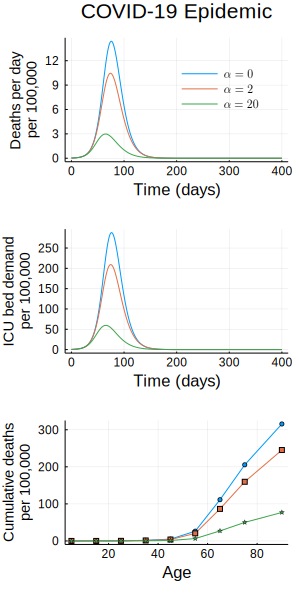

In [12]:
#Make plots
txtsize=10
SCALING = 100_000
p1,p2,p3,DD1,DD2,DD3 = PlotResults2!(sol_alph0,sol_alph2,sol_alph20,params0,params2,params20,MiddleAge,"COVID-19 Epidemic",txtsize,SCALING);
ll = @layout[a;b;c]
plot(p1,p2,p3,layout=ll,size=(300,600))
savefig("core_model_9ageclasses_epidemic_lowR0.pdf")
current() #display the figure

Epidemic outcomes. Numbers are per 100,000 people. $\alpha$ is the level of serological shielding. Last age category is 80 and older.

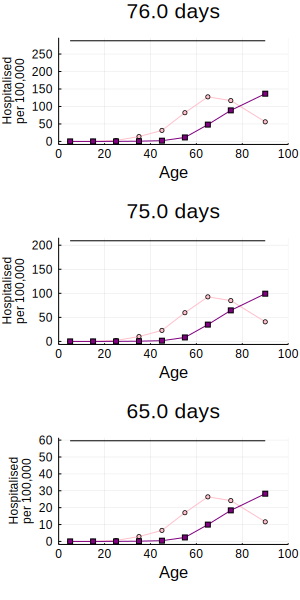

In [13]:
LL = @layout[a; b; c]
p1,s1 = PlotHosp!(sol_alph0)
p2,s2 = PlotHosp!(sol_alph2)
p3,s3 = PlotHosp!(sol_alph20)
plot(p1,p2,p3,layout=LL,legend=false,size = (300,600))
savefig("hospital_peak_demand_9ageclasses_lowR0.pdf")
current()

Age structured subacute (pink) and critical (purple) hospitalised cases at epidemic peaks for the 3 scenarios. Time shown is that of the epidemic peak. From top to bottom the level of serological shielding is $\alpha=0$, $\alpha=2$, $\alpha=20$. Black line indicates total ICU beds required (across all age classes) at this time.

## High R0 dynamics

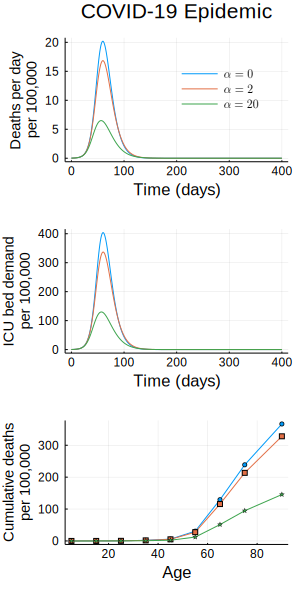

In [14]:
#Make plots
txtsize=10
SCALING = 100_000
p1,p2,p3,DD1,DD2,DD3 = PlotResults2!(sol_alph0h,sol_alph2h,sol_alph20h,params0h,params2h,params20h,MiddleAge,"COVID-19 Epidemic",txtsize,SCALING);
ll = @layout[a;b;c]
plot(p1,p2,p3,layout=ll,size=(300,600))
savefig("core_model_9ageclasses_epidemic_highR0.pdf")
current() #display the figure

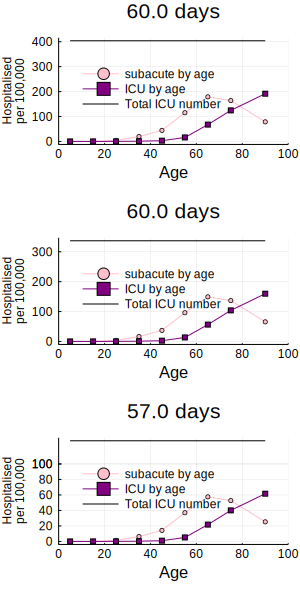

In [15]:
LL = @layout[a; b; c]
p1,s1 = PlotHosp!(sol_alph0h)
p2,s2 = PlotHosp!(sol_alph2h)
p3,s3 = PlotHosp!(sol_alph20h)
plot(p1,p2,p3,layout=LL,size = (300,600))
savefig("hospital_peak_demand_9ageclasses_highR0.pdf")
current()

## Effects of demography on epidemic spread<a id="demography"></a>


Here, we investigate the effect of different age distributions and population sizes across different US states on the spread of the disease. In all cases we start from the same outbreak conditions of 10,000 people aged 20-29 who are infected. This is done by finding the distribution of cases when the outbreak is initialised from one exposed case. 

Data for age structure and population size is taken from the US census, for the year 2018.
(This data has been parsed from the raw data within the state directory using a seperate R script). This includes the US, its 50 states, the District of Columbia and Puerto Rico.

In [16]:
#read in data
stateDemog = CSV.read("Demography\\state\\STATE_DEMOG.csv")

53×11 DataFrames.DataFrame. Omitted printing of 6 columns
│ Row │ Column1              │ 0to9      │ 10to19   │ 20to29   │ 30to39   │
│     │ String               │ Float64   │ Float64  │ Float64  │ Float64  │
├─────┼──────────────────────┼───────────┼──────────┼──────────┼──────────┤
│ 1   │ United States        │ 0.12228   │ 0.128304 │ 0.138875 │ 0.13357  │
│ 2   │ Alabama              │ 0.120933  │ 0.128108 │ 0.136099 │ 0.124291 │
│ 3   │ Alaska               │ 0.142617  │ 0.13021  │ 0.155501 │ 0.147626 │
│ 4   │ Arizona              │ 0.123774  │ 0.132496 │ 0.140854 │ 0.129224 │
│ 5   │ Arkansas             │ 0.127289  │ 0.132222 │ 0.135421 │ 0.126671 │
│ 6   │ California           │ 0.124635  │ 0.12876  │ 0.147575 │ 0.143412 │
│ 7   │ Colorado             │ 0.120235  │ 0.127949 │ 0.146153 │ 0.150217 │
│ 8   │ Connecticut          │ 0.106124  │ 0.1287   │ 0.130446 │ 0.123253 │
│ 9   │ Delaware             │ 0.114828  │ 0.122023 │ 0.129583 │ 0.125038 │
│ 10  │ District of Columbia │ 0.118497  │ 0.093206 │ 0.193635 │ 0.203861 │
⋮
│ 43  │ South Dakota         │ 0.139298  │ 0.134381 │ 0.134135 │ 0.128478 │
│ 44  │ Tennessee            │ 0.120962  │ 0.126357 │ 0.13857  │ 0.128727 │
│ 45  │ Texas                │ 0.141868  │ 0.143676 │ 0.144881 │ 0.143104 │
│ 46  │ Utah                 │ 0.161995  │ 0.163166 │ 0.160747 │ 0.14205  │
│ 47  │ Vermont              │ 0.0973225 │ 0.121421 │ 0.133684 │ 0.116816 │
│ 48  │ Virginia             │ 0.120383  │ 0.125697 │ 0.138887 │ 0.136745 │
│ 49  │ Washington           │ 0.123364  │ 0.12074  │ 0.142108 │ 0.14596  │
│ 50  │ West Virginia        │ 0.108703  │ 0.117184 │ 0.125542 │ 0.116831 │
│ 51  │ Wisconsin            │ 0.117687  │ 0.128624 │ 0.13251  │ 0.126383 │
│ 52  │ Wyoming              │ 0.127669  │ 0.130539 │ 0.13301  │ 0.135108 │
│ 53  │ Puerto Rico          │ 0.0906767 │ 0.122098 │ 0.135828 │ 0.116605 │

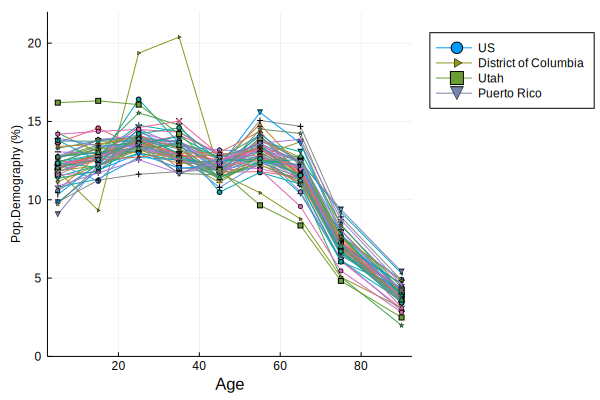

In [17]:
#Plot age distributions

IND=1
    row = vec(convert(Array, stateDemog[IND,:]))
    POPNOW = POPDEMOG(row[2:10],row[11])
  prr=  plot(MiddleAge,POPNOW.AgeStructure*100.0,xlabel="Age",legend=:outertopright,ylims=(0,22),ylabel = "Pop.Demography (%)",label = "US",yguidefontsize=8,markershape = :auto,markersize=2)


    
    
for aa=2:(size(stateDemog)[1]) #for each row entry in stateDemog
    IND=aa
    row = vec(convert(Array, stateDemog[IND,:]))
    POPNOW = POPDEMOG(row[2:10],row[11])
    if sum(aa .== [10,46,53])==1
        plot!(prr,MiddleAge,POPNOW.AgeStructure*100.0,label=stateDemog.Column1[IND],markershape = :auto,markersize=2)
    else
        plot!(prr,MiddleAge,POPNOW.AgeStructure*100.0,label="",markershape = :auto,markersize=2)
    end
end
savefig("StateDemography.pdf")
current()

Age-structure for the US, its 50 states, the District of Columbia, and Puerto Rico. A few are labelled for reference. Utah has the largest 0-20 year old age-fraction of its demographic. The District of Columbia has much larger group of 20-40 year olds than is typical. Puerto Rico has the smallest fraction of 0-10 year olds, and the largest fraction of 80+ year olds.

### Georgia COVID-19 dynamics<a id="GA"></a>

#### Low R0 outbreak

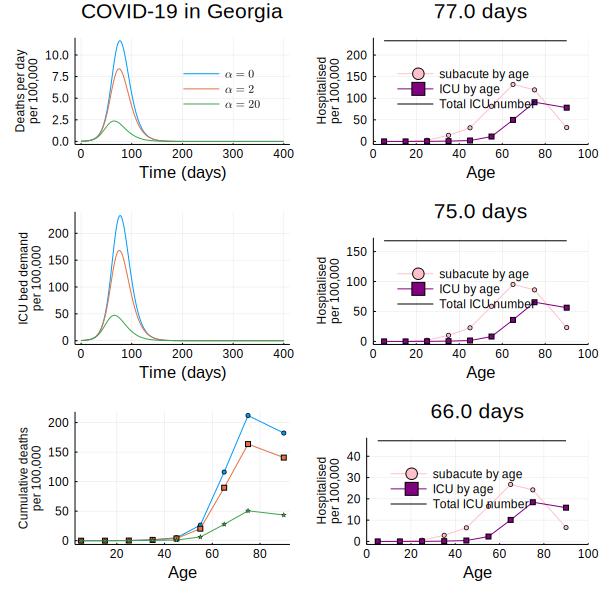

In [18]:
#Example run : Georgia
    IND=12
    row = vec(convert(Array, stateDemog[IND,:]))
    POPNOW = POPDEMOG(row[2:10],row[11])
    
    #1. outbreak
    uss0 = zeros(NumAgeClasses*NumEpiStates) #vector of initial states
    uss0[S_ind] = POPNOW.AgeStructure.*POPNOW.PopulationSize #put everything in S
    uss0[3] = uss0[3]-1 #remove infected from S ages 20-29
    uss0[3+NumAgeClasses] = 1  #assign E cases ages 20-29
    uss0 = uss0./POPNOW.PopulationSize;  #renormalise
    
    #2. assign and solve initial (before intervention) problems 
    tspan = (0.0,400.0) #run the simulations between 0 days and 400 days
    #define problems
    prob = ODEProblem(SerologicalShieldsStates!,uss0,tspan,params0)

    #set up callback to stop integration when number of cases reaches a threshold
    CaseThreshold = 10_000/POP.PopulationSize;
    condition(u,t,integrator)  = sum(u[S_ind]) - (1 - CaseThreshold)  #this must be equal to zero at stopping condition
    affect!(integrator) = terminate!(integrator) 
    cb = ContinuousCallback(condition,affect!)
    
    #solve the initial spin up, checking for positivity and using callback definition 
    SOLinit = solve(prob,Tsit5(),abstol=1e-8,reltol=1e-8,saveat=1,isoutofdomain=(y,p,t)->any(x->x<0,y),callback=cb)
    
    #new initial condition
    uInit = SOLinit.u[end] #last u at time when at CaseThreshold cases

    #3. define the intervention policy problems
    prob0 = ODEProblem(SerologicalShieldsStates!,uInit,tspan,params0)
    prob2 = ODEProblem(SerologicalShieldsStates!,uInit,tspan,params2)
    prob20 = ODEProblem(SerologicalShieldsStates!,uInit,tspan,params20)
    
    #4. solve
    #run the simulations (checking for positivity of solutions)
    sol_0 = solve(prob0 ,Tsit5(),abstol=1e-8,reltol=1e-8,saveat=1,isoutofdomain=(y,p,t)->any(x->x<0,y)) 
    sol_2 = solve(prob2 ,Tsit5(),abstol=1e-8,reltol=1e-8,saveat=1,isoutofdomain=(y,p,t)->any(x->x<0,y))
    sol_20 = solve(prob20 ,Tsit5(),abstol=1e-8,reltol=1e-8,saveat=1,isoutofdomain=(y,p,t)->any(x->x<0,y))



#Make plots
txtsize=8
SCALING = 100_000

LL = @layout[a b;c d;e f]
p1,p3,p5,DD1,DD2,DD3 = PlotResults2!(sol_0,sol_2,sol_20,params0,params2,params20,MiddleAge,"COVID-19 in Georgia",txtsize,SCALING);
p2,s1 = PlotHosp!(sol_0)
p4,s2 = PlotHosp!(sol_2)
p6,s3 = PlotHosp!(sol_20)
plot(p1,p2,p3,p4,p5,p6,layout=LL,size = (600,600))
savefig("COVID19_GA_lowR0.pdf")
current()

Left) Dynamics of COVID-19 epidemic the population demography of Georgia. A: Deaths per 100,00000 per day. B: ICU bed demand per 100,000. C: Cumulative deaths per 100,000 across age groups. Right) Hospital demand at the epidemic peak. Title shows approximate timing of the peak. Black horizontal line shows peak ICU demand per 100,000 across all age groups, whilst the marked lines represent subacute and ICU medical demand by age. D: with no serological shields. E: With $\alpha$=2. F: with $\alpha$=20.

#### High R0 outbreak

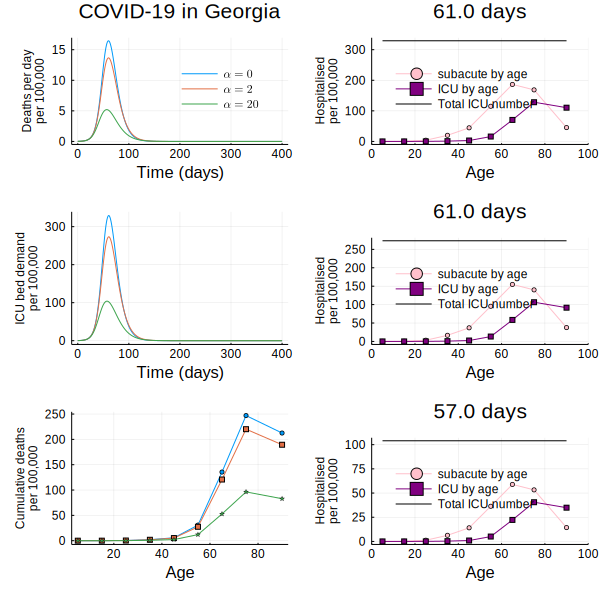

In [19]:
#Example run : Georgia
    IND=12
    row = vec(convert(Array, stateDemog[IND,:]))
    POPNOW = POPDEMOG(row[2:10],row[11])
    
    #1. outbreak
    uss0 = zeros(NumAgeClasses*NumEpiStates) #vector of initial states
    uss0[S_ind] = POPNOW.AgeStructure.*POPNOW.PopulationSize #put everything in S
    uss0[3] = uss0[3]-1 #remove infected from S ages 20-29
    uss0[3+NumAgeClasses] = 1  #assign E cases ages 20-29
    uss0 = uss0./POPNOW.PopulationSize;  #renormalise
    
    #2. assign and solve initial (before intervention) problems 
    tspan = (0.0,400.0) #run the simulations between 0 days and 400 days
    #define problems
    prob = ODEProblem(SerologicalShieldsStates!,uss0,tspan,params0h)

    #set up callback to stop integration when number of cases reaches a threshold
    CaseThreshold = 10_000/POP.PopulationSize;
    condition(u,t,integrator)  = sum(u[S_ind]) - (1 - CaseThreshold)  #this must be equal to zero at stopping condition
    affect!(integrator) = terminate!(integrator) 
    cb = ContinuousCallback(condition,affect!)
    
    #solve the initial spin up, checking for positivity and using callback definition 
    SOLinit = solve(prob,Tsit5(),abstol=1e-8,reltol=1e-8,saveat=1,isoutofdomain=(y,p,t)->any(x->x<0,y),callback=cb)
    
    #new initial condition
    uInit = SOLinit.u[end] #last u at time when at CaseThreshold cases

    #3. define the intervention policy problems
    prob0 = ODEProblem(SerologicalShieldsStates!,uInit,tspan,params0h)
    prob2 = ODEProblem(SerologicalShieldsStates!,uInit,tspan,params2h)
    prob20 = ODEProblem(SerologicalShieldsStates!,uInit,tspan,params20h)
    
    #4. solve
    #run the simulations (checking for positivity of solutions)
    sol_0 = solve(prob0 ,Tsit5(),abstol=1e-8,reltol=1e-8,saveat=1,isoutofdomain=(y,p,t)->any(x->x<0,y)) 
    sol_2 = solve(prob2 ,Tsit5(),abstol=1e-8,reltol=1e-8,saveat=1,isoutofdomain=(y,p,t)->any(x->x<0,y))
    sol_20 = solve(prob20 ,Tsit5(),abstol=1e-8,reltol=1e-8,saveat=1,isoutofdomain=(y,p,t)->any(x->x<0,y))



#Make plots
txtsize=8
SCALING = 100_000
LL = @layout[a b;c d;e f]
p1,p3,p5,DD1,DD2,DD3 = PlotResults2!(sol_0,sol_2,sol_20,params0h,params2h,params20h,MiddleAge,"COVID-19 in Georgia",txtsize,SCALING);
p2,s1 = PlotHosp!(sol_0)
p4,s2 = PlotHosp!(sol_2)
p6,s3 = PlotHosp!(sol_20)
plot(p1,p2,p3,p4,p5,p6,layout=LL,size = (600,600))
savefig("COVID19_GA_highR0.pdf")
current()

## Analysis of serological shielding across states with fraction over 60 low R0<a id="acrossStates"></a>


In [20]:
function AnalyseSols(sol,par)
    Sols =  hcat(sol.u...)
    
    SS,EE,IA,IS,Ihs,Ihc,RR,DD,D_per_day,D_by_age = PopWideStates_ss!(sol,par)
    
    S_Ihs = zeros(NumAgeClasses)#shape of I_h,sub (t=max)
    S_Ihc = zeros(NumAgeClasses) #shape of I_h,crit (t=max)
    S_D = D_by_age #shape of D(t=end)
    sumDD = DD[end] # sum of D (all those who are killed)
    sumSS = SS[end] # sum of S (those not exposed to virus)
    
    
    maxtimeICUi = findmax(Ihc)[2]
    maxtimeICU = sol.t[findmax(Ihc)[2]]
    maxtimeH = sol.t[findmax(Ihc.+Ihs)[2]]
    S_Ihs = Sols[Ihsub_ind,maxtimeICUi]
    S_Ihc = Sols[Ihcrit_ind,maxtimeICUi]
    sumIhs = Ihs[maxtimeICUi]
    sumIhc = Ihc[maxtimeICUi]
    
    return sumSS,sumDD,sumIhs,sumIhc,maxtimeICU,maxtimeH,S_D,S_Ihs,S_Ihc
end
    

AnalyseSols (generic function with 1 method)

### Low R0 scenarios

In [21]:
#output storage...
Nstates = 53
SSS = zeros(3,Nstates)
IHS = zeros(3,Nstates)
IHC = zeros(3,Nstates)
DDD = zeros(3,Nstates)
T_MAXICU = zeros(3,Nstates)
T_MAXH = zeros(3,Nstates)
S_D = zeros(3,Nstates,NumAgeClasses)
S_Ihs = zeros(3,Nstates,NumAgeClasses)
S_Ihc = zeros(3,Nstates,NumAgeClasses)

for aa = 1:Nstates #for each row entry in stateDemog
    IND=aa
    row = vec(convert(Array, stateDemog[IND,:]))
    POPNOW = POPDEMOG(row[2:10],row[11])
    
    #1. outbreak
    uss0 = zeros(NumAgeClasses*NumEpiStates) #vector of initial states
    uss0[S_ind] = POPNOW.AgeStructure.*POPNOW.PopulationSize #put everything in S
    uss0[3] = uss0[3]-1 #remove infected from S ages 20-29
    uss0[3+NumAgeClasses] = 1  #assign E cases ages 20-29
    uss0 = uss0./POPNOW.PopulationSize;  #renormalise
    
    #2. assign and solve initial (before intervention) problems 
    tspan = (0.0,400.0) #run the simulations between 0 days and 400 days
    #define problems
    prob = ODEProblem(SerologicalShieldsStates!,uss0,tspan,params0)

    #set up callback to stop integration when number of cases reaches a threshold
    CaseThreshold = 10_000/POP.PopulationSize;
    condition(u,t,integrator)  = sum(u[S_ind]) - (1 - CaseThreshold)  #this must be equal to zero at stopping condition
    affect!(integrator) = terminate!(integrator) 
    cb = ContinuousCallback(condition,affect!)
    
    #solve the initial spin up, checking for positivity and using callback definition 
    SOLinit = solve(prob,Tsit5(),abstol=1e-8,reltol=1e-8,saveat=1,isoutofdomain=(y,p,t)->any(x->x<0,y),callback=cb)
    
    #new initial condition
    uInit = SOLinit.u[end] #last u at time when at CaseThreshold cases

    #3. define the intervention policy problems
    prob0 = ODEProblem(SerologicalShieldsStates!,uInit,tspan,params0)
    prob2 = ODEProblem(SerologicalShieldsStates!,uInit,tspan,params2)
    prob20 = ODEProblem(SerologicalShieldsStates!,uInit,tspan,params20)
    
    #4. solve
    #run the simulations (checking for positivity of solutions)
    sol_0 = solve(prob0 ,Tsit5(),abstol=1e-8,reltol=1e-8,saveat=1,isoutofdomain=(y,p,t)->any(x->x<0,y)) 
    sol_2 = solve(prob2 ,Tsit5(),abstol=1e-8,reltol=1e-8,saveat=1,isoutofdomain=(y,p,t)->any(x->x<0,y))
    sol_20 = solve(prob20 ,Tsit5(),abstol=1e-8,reltol=1e-8,saveat=1,isoutofdomain=(y,p,t)->any(x->x<0,y))
    
    #4. analyse
    Asol_0 = AnalyseSols(sol_0,params0)
    Asol_2 = AnalyseSols(sol_2,params2)
    Asol_20 = AnalyseSols(sol_20,params20)

    
    #5. Store output
    SSS[1,aa],DDD[1,aa],IHS[1,aa],IHC[1,aa],T_MAXICU[1,aa],T_MAXH[1,aa],S_D[1,aa,:],S_Ihs[1,aa,:],S_Ihc[1,aa,:] = Asol_0 
    SSS[2,aa],DDD[2,aa],IHS[2,aa],IHC[2,aa],T_MAXICU[2,aa],T_MAXH[2,aa],S_D[2,aa,:],S_Ihs[2,aa,:],S_Ihc[2,aa,:] = Asol_2 
    SSS[3,aa],DDD[3,aa],IHS[3,aa],IHC[3,aa],T_MAXICU[3,aa],T_MAXH[3,aa],S_D[3,aa,:],S_Ihs[3,aa,:],S_Ihc[3,aa,:] = Asol_20 

end

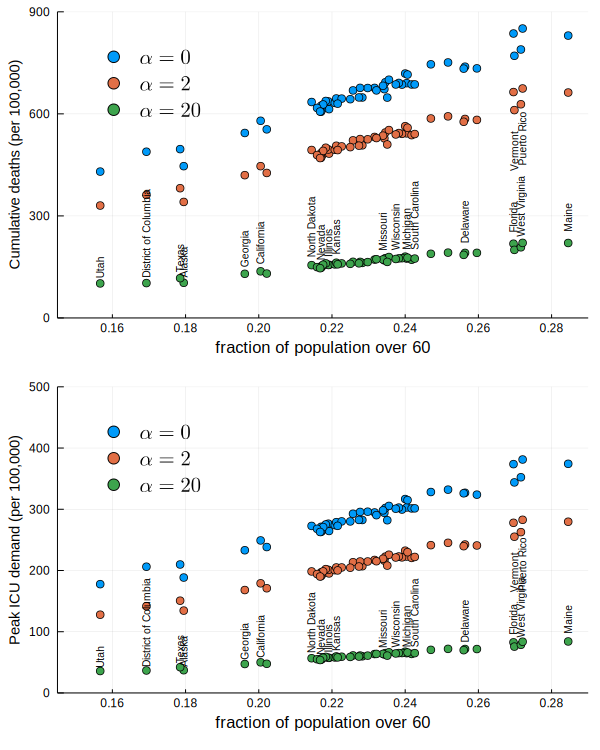

In [22]:
L2 = @layout [a; b]

p1 = scatter((stateDemog[2:53,8].+stateDemog[2:53,9].+stateDemog[2:53,10]),100_000*(DDD[1,2:53]),
    legend=:topleft,xlim=(0.145,0.29),ylim=(0,900),label = L"\alpha=0",
        foreground_color_legend = nothing,background_color_legend=nothing, yguidefontsize=10,legendfontsize=14)
xlabel!("fraction of population over 60")
ylabel!("Cumulative deaths (per 100,000)")

font2 = text("").font
font2.rotation = 90
font2.pointsize = 7
font3 = text("").font
font3.pointsize=8
scatter!((stateDemog[2:53,8].+stateDemog[2:53,9].+stateDemog[2:53,10]),100_000*(DDD[2,2:53]),label= L"\alpha=2")
scatter!((stateDemog[2:53,8].+stateDemog[2:53,9].+stateDemog[2:53,10]),100_000*(DDD[3,2:53]),label= L"\alpha=20")

for aa=2:53
    if mod(aa,3)==0 || sum(aa.==[50,46,10,11])==1
        if sum(aa.==[33,39,48])==0
annotate!((stateDemog[aa,8].+stateDemog[aa,9].+stateDemog[aa,10]),115_000*(DDD[3,aa]), text(stateDemog.Column1[aa],font2,:left))
    #else
#annotate!((stateDemog[aa,8].+stateDemog[aa,9].+stateDemog[aa,10]),80_000*(DDD[2,aa]), text(stateDemog.Column1[aa],font2,:right))
        end
    end
    if sum(aa.==[53,47])==1
        annotate!((stateDemog[aa,8].+stateDemog[aa,9].+stateDemog[aa,10]),90_000*(DDD[2,aa]), text(stateDemog.Column1[aa],font2,:right))
    end
end

p2 = scatter((stateDemog[2:53,8].+stateDemog[2:53,9].+stateDemog[2:53,10]),100_000*(IHC[1,2:53]),
    legend=:topleft,xlim=(0.145,0.29),ylim=(0,500),label = L"\boldmath\alpha=0",
        foreground_color_legend = nothing,background_color_legend=nothing, yguidefontsize=10,legendfontsize=14)
xlabel!("fraction of population over 60")
ylabel!("Peak ICU demand (per 100,000)")
font3 = text("").font
font3.pointsize=8
scatter!((stateDemog[2:53,8].+stateDemog[2:53,9].+stateDemog[2:53,10]),100_000*(IHC[2,2:53]),label=  L"\boldmath\alpha=2")
scatter!((stateDemog[2:53,8].+stateDemog[2:53,9].+stateDemog[2:53,10]),100_000*(IHC[3,2:53]),label= L"\boldmath\alpha=20")

for aa=2:53
    if mod(aa,3)==0 || sum(aa.==[50,46,10,11])==1
        if sum(aa.==[33,39,48])==0
annotate!((stateDemog[aa,8].+stateDemog[aa,9].+stateDemog[aa,10]),115_000*(IHC[3,aa]), text(stateDemog.Column1[aa],font2,:left))
    #else
#annotate!((stateDemog[aa,8].+stateDemog[aa,9].+stateDemog[aa,10]),80_000*(DDD[2,aa]), text(stateDemog.Column1[aa],font2,:right))
        end
    end
    if sum(aa.==[53,47])==1
        annotate!((stateDemog[aa,8].+stateDemog[aa,9].+stateDemog[aa,10]),90_000*(IHC[2,aa]), text(stateDemog.Column1[aa],font2,:right))
    end
end


plot(p1,p2,layout=L2,size=(600,750))
savefig("Effect_alpha_death_ICU_scatter_lowR0.pdf")
current()

In [23]:
#Find slope coefficients for fraction of population over 60 with cumulative deaths (per 100,000 people)
X = ones(52,2)
X[:,2] = (stateDemog[2:53,8].+stateDemog[2:53,9].+stateDemog[2:53,10])
Y = 100_000*(DDD[1,2:53])
b1=(X'X)\(X'Y)

Y = 100_000*(DDD[2,2:53])
b2=(X'X)\(X'Y)

Y = 100_000*(DDD[3,2:53])
b3=(X'X)\(X'Y)


[b1 , b2 , b3 ] #intecepts in first column, slope coefficients in second column.

3-element Array{Array{Float64,1},1}:
 [-101.67371718202664, 3330.4726297847465]
 [-125.16203370006868, 2807.4827840950575]
 [-70.12706277531697, 1027.9303792398946] 

In [24]:
#Find slope coefficients for fraction of population over 60 with peak ICU demand (per 100,000 people)
X = ones(52,2)
X[:,2] = (stateDemog[2:53,8].+stateDemog[2:53,9].+stateDemog[2:53,10])
Y = 100_000*(IHC[1,2:53])
b1=(X'X)\(X'Y)

Y = 100_000*(IHC[2,2:53])
b2=(X'X)\(X'Y)

Y = 100_000*(IHC[3,2:53])
b3=(X'X)\(X'Y)


[b1 , b2 , b3 ] #intecepts in first column, slope coefficients in second column.


3-element Array{Array{Float64,1},1}:
 [-81.38105507072997, 1615.7788040973844]
 [-79.22882472263983, 1269.5742390440453]
 [-33.13164937273237, 412.27668325294366]

In [25]:
#Difference Maine-Utah
print((DDD[1,21]-DDD[1,46])*100_000) # baseline
(DDD[3,21]-DDD[3,46])*100_000 #alpha = 20

399.8205375502182

118.8621474621317

## State by state outcomes low R0<a id=bars></a>

Below we plot the peak ICU demand, peak hospital demand, and cumulative deaths per state both on a per 100,000 person basis and total estimates for each state with and without serological shielding. 

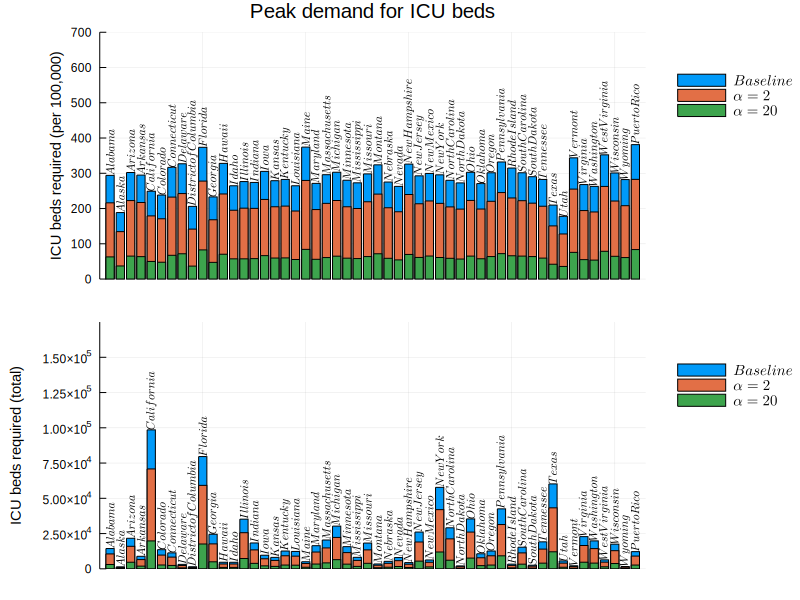

In [26]:
THING = IHC[1:3,2:end]
TITLE = "Peak demand for ICU beds"
YLAB1 = "ICU beds required (per 100,000)"
YLAB2 = "ICU beds required  (total)"
gr()
LL = @layout[a;b]
p1 = bar(THING[1,:] .* 100_000,xlim=(0,53),
    yguidefontsize=10,xaxis=false,ylim=(0,700),
    title = TITLE, label=L"Baseline",
    legend = :outertopright,foreground_color_legend = nothing,background_color_legend=nothing)
bar!(THING[2,:] .* 100_000, label=L"\alpha=2")
bar!(THING[3,:] .* 100_000, label=L"\alpha=20")

font2 = text("").font
font2.rotation = 90
font2.pointsize = 8
for aa = 1:52
annotate!(aa,THING[1,aa] .*100_000+ 0.5, text(latexstring(stateDemog.Column1[aa+1]), font2, :left))
end
ylabel!(YLAB1)

p2 = bar(THING[1,:] .* stateDemog.POPTOTAL[2:end],xlim=(0,53),
    legend = :outertopright,foreground_color_legend = nothing,background_color_legend=nothing,
    yguidefontsize=10,xaxis=false,ylim=(0,17.5*10^4), label=L"Baseline")
bar!(THING[2,:] .* stateDemog.POPTOTAL[2:end],label=L"\alpha=2")
bar!(THING[3,:] .* stateDemog.POPTOTAL[2:end],label=L"\alpha=20")


for aa = 1:52
annotate!(aa,THING[1,aa] .* stateDemog.POPTOTAL[aa+1] +100, text(latexstring(stateDemog.Column1[aa+1]), font2,:left))
end
ylabel!(YLAB2)

plot(p1,p2,layout=LL,size =(800,600))
savefig("ICUdemand_bars_byState_lowR0.pdf")
savefig("ICUdemand_bars_byState_lowR0.png")
current()

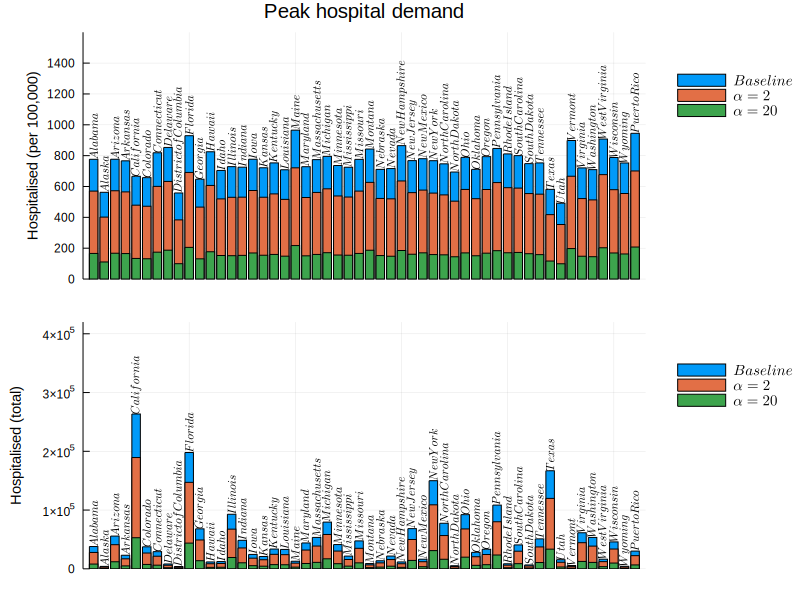

In [27]:
THING = IHS[1:3,2:end] .+ IHC[1:3,2:end]
TITLE = "Peak hospital demand"
YLAB1 = "Hospitalised (per 100,000)"
YLAB2 = "Hospitalised  (total)"
gr()
LL = @layout[a;b]
p1 = bar(THING[1,:] .* 100_000,xlim=(0,53),
    yguidefontsize=10,xaxis=false,ylim=(0,1600),
    title = TITLE, label=L"Baseline",
    legend = :outertopright,foreground_color_legend = nothing,background_color_legend=nothing)
bar!(THING[2,:] .* 100_000, label=L"\alpha=2")
bar!(THING[3,:] .* 100_000, label=L"\alpha=20")

font2 = text("").font
font2.rotation = 90
font2.pointsize = 8
for aa = 1:52
annotate!(aa,THING[1,aa] .*100_000+ 0.5, text(latexstring(stateDemog.Column1[aa+1]), font2, :left))
end
ylabel!(YLAB1)

p2 = bar(THING[1,:] .* stateDemog.POPTOTAL[2:end],xlim=(0,53),
    legend = :outertopright,foreground_color_legend = nothing,background_color_legend=nothing,
    yguidefontsize=10,xaxis=false,ylim=(0,4.2*10^5), label=L"Baseline")
bar!(THING[2,:] .* stateDemog.POPTOTAL[2:end],label=L"\alpha=2")
bar!(THING[3,:] .* stateDemog.POPTOTAL[2:end],label=L"\alpha=20")


for aa = 1:52
annotate!(aa,THING[1,aa] .* stateDemog.POPTOTAL[aa+1] +100, text(latexstring(stateDemog.Column1[aa+1]), font2,:left))
end
ylabel!(YLAB2)

plot(p1,p2,layout=LL,size =(800,600))
savefig("Hospdemand_bars_byState_lowR0.pdf")
savefig("Hospdemand_bars_byState_lowR0.png")
current()

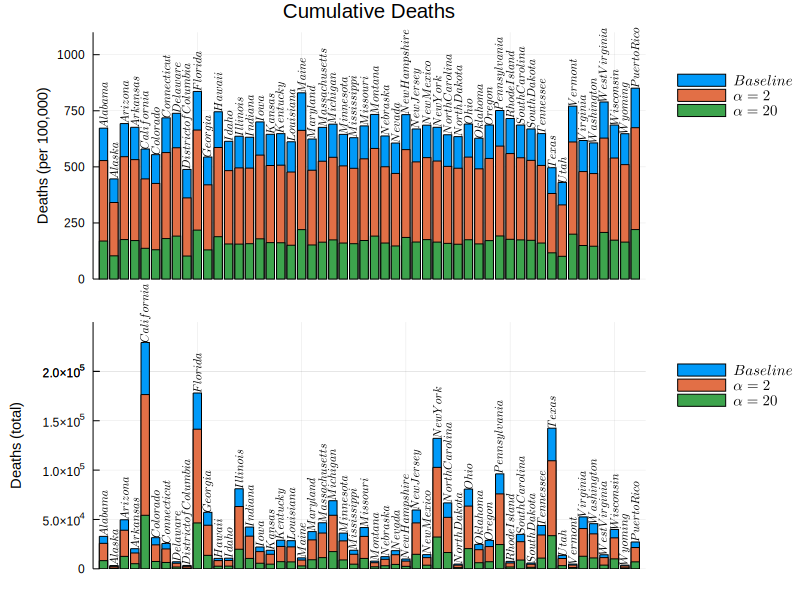

In [28]:
THING = DDD[1:3,2:end]
TITLE = "Cumulative Deaths"
YLAB1 = "Deaths (per 100,000)"
YLAB2 = "Deaths  (total)"
gr()
LL = @layout[a;b]
p1 = bar(THING[1,:] .* 100_000,xlim=(0,53),
    yguidefontsize=10,xaxis=false,ylim=(0,1100),
    title = TITLE, label=L"Baseline",
    legend = :outertopright,foreground_color_legend = nothing,background_color_legend=nothing)
bar!(THING[2,:] .* 100_000, label=L"\alpha=2")
bar!(THING[3,:] .* 100_000, label=L"\alpha=20")

font2 = text("").font
font2.rotation = 90
font2.pointsize = 8
for aa = 1:52
annotate!(aa,THING[1,aa] .*100_000+ 0.5, text(latexstring(stateDemog.Column1[aa+1]), font2, :left))
end
ylabel!(YLAB1)

p2 = bar(THING[1,:] .* stateDemog.POPTOTAL[2:end],xlim=(0,53),
    legend = :outertopright,foreground_color_legend = nothing,background_color_legend=nothing,
    yguidefontsize=10,xaxis=false,ylim=(0,2.5*10^5), label=L"Baseline")
bar!(THING[2,:] .* stateDemog.POPTOTAL[2:end],label=L"\alpha=2")
bar!(THING[3,:] .* stateDemog.POPTOTAL[2:end],label=L"\alpha=20")


for aa = 1:52
annotate!(aa,THING[1,aa] .* stateDemog.POPTOTAL[aa+1] +100, text(latexstring(stateDemog.Column1[aa+1]), font2,:left))
end
ylabel!(YLAB2)

plot(p1,p2,layout=LL,size =(800,600))
savefig("Dead_bars_byState_lowR0.pdf")
savefig("Dead_bars_byState_lowR0.png")
current()

## Analysis of serological shielding across states with fraction over 60 high R0<a id="acrossStates"></a>


### High R0 scenarios

In [29]:
#output storage...
Nstates = 53
SSS = zeros(3,Nstates)
IHS = zeros(3,Nstates)
IHC = zeros(3,Nstates)
DDD = zeros(3,Nstates)
T_MAXICU = zeros(3,Nstates)
T_MAXH = zeros(3,Nstates)
S_D = zeros(3,Nstates,NumAgeClasses)
S_Ihs = zeros(3,Nstates,NumAgeClasses)
S_Ihc = zeros(3,Nstates,NumAgeClasses)

for aa = 1:Nstates #for each row entry in stateDemog
    IND=aa
    row = vec(convert(Array, stateDemog[IND,:]))
    POPNOW = POPDEMOG(row[2:10],row[11])
    
    #1. outbreak
    uss0 = zeros(NumAgeClasses*NumEpiStates) #vector of initial states
    uss0[S_ind] = POPNOW.AgeStructure.*POPNOW.PopulationSize #put everything in S
    uss0[3] = uss0[3]-1 #remove infected from S ages 20-29
    uss0[3+NumAgeClasses] = 1  #assign E cases ages 20-29
    uss0 = uss0./POPNOW.PopulationSize;  #renormalise
    
    #2. assign and solve initial (before intervention) problems 
    tspan = (0.0,400.0) #run the simulations between 0 days and 400 days
    #define problems
    prob = ODEProblem(SerologicalShieldsStates!,uss0,tspan,params0h)

    #set up callback to stop integration when number of cases reaches a threshold
    CaseThreshold = 10_000/POP.PopulationSize;
    condition(u,t,integrator)  = sum(u[S_ind]) - (1 - CaseThreshold)  #this must be equal to zero at stopping condition
    affect!(integrator) = terminate!(integrator) 
    cb = ContinuousCallback(condition,affect!)
    
    #solve the initial spin up, checking for positivity and using callback definition 
    SOLinit = solve(prob,Tsit5(),abstol=1e-8,reltol=1e-8,saveat=1,isoutofdomain=(y,p,t)->any(x->x<0,y),callback=cb)
    
    #new initial condition
    uInit = SOLinit.u[end] #last u at time when at CaseThreshold cases

    #3. define the intervention policy problems
    prob0 = ODEProblem(SerologicalShieldsStates!,uInit,tspan,params0h)
    prob2 = ODEProblem(SerologicalShieldsStates!,uInit,tspan,params2h)
    prob20 = ODEProblem(SerologicalShieldsStates!,uInit,tspan,params20h)
    
    #4. solve
    #run the simulations (checking for positivity of solutions)
    sol_0 = solve(prob0 ,Tsit5(),abstol=1e-8,reltol=1e-8,saveat=1,isoutofdomain=(y,p,t)->any(x->x<0,y)) 
    sol_2 = solve(prob2 ,Tsit5(),abstol=1e-8,reltol=1e-8,saveat=1,isoutofdomain=(y,p,t)->any(x->x<0,y))
    sol_20 = solve(prob20 ,Tsit5(),abstol=1e-8,reltol=1e-8,saveat=1,isoutofdomain=(y,p,t)->any(x->x<0,y))
    
    #4. analyse
    Asol_0 = AnalyseSols(sol_0,params0)
    Asol_2 = AnalyseSols(sol_2,params2)
    Asol_20 = AnalyseSols(sol_20,params20)

    
    #5. Store output
    SSS[1,aa],DDD[1,aa],IHS[1,aa],IHC[1,aa],T_MAXICU[1,aa],T_MAXH[1,aa],S_D[1,aa,:],S_Ihs[1,aa,:],S_Ihc[1,aa,:] = Asol_0 
    SSS[2,aa],DDD[2,aa],IHS[2,aa],IHC[2,aa],T_MAXICU[2,aa],T_MAXH[2,aa],S_D[2,aa,:],S_Ihs[2,aa,:],S_Ihc[2,aa,:] = Asol_2 
    SSS[3,aa],DDD[3,aa],IHS[3,aa],IHC[3,aa],T_MAXICU[3,aa],T_MAXH[3,aa],S_D[3,aa,:],S_Ihs[3,aa,:],S_Ihc[3,aa,:] = Asol_20 

end

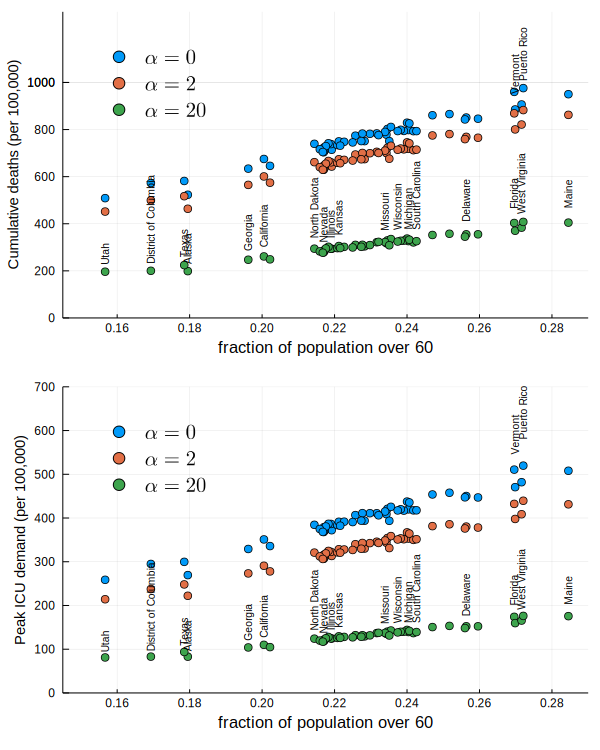

In [30]:
L2 = @layout [a; b]

p1 = scatter((stateDemog[2:53,8].+stateDemog[2:53,9].+stateDemog[2:53,10]),100_000*(DDD[1,2:53]),
    legend=:topleft,xlim=(0.145,0.29),ylim=(0,1300),label = L"\alpha=0",
        foreground_color_legend = nothing,background_color_legend=nothing, yguidefontsize=10,legendfontsize=14)
xlabel!("fraction of population over 60")
ylabel!("Cumulative deaths (per 100,000)")

font2 = text("").font
font2.rotation = 90
font2.pointsize = 7
font3 = text("").font
font3.pointsize=8
scatter!((stateDemog[2:53,8].+stateDemog[2:53,9].+stateDemog[2:53,10]),100_000*(DDD[2,2:53]),label= L"\alpha=2")
scatter!((stateDemog[2:53,8].+stateDemog[2:53,9].+stateDemog[2:53,10]),100_000*(DDD[3,2:53]),label= L"\alpha=20")

for aa=2:53
    if mod(aa,3)==0 || sum(aa.==[50,46,10,11])==1
        if sum(aa.==[33,39,48])==0
annotate!((stateDemog[aa,8].+stateDemog[aa,9].+stateDemog[aa,10]),115_000*(DDD[3,aa]), text(stateDemog.Column1[aa],font2,:left))
    #else
#annotate!((stateDemog[aa,8].+stateDemog[aa,9].+stateDemog[aa,10]),80_000*(DDD[2,aa]), text(stateDemog.Column1[aa],font2,:right))
        end
    end
    if sum(aa.==[53,47])==1
        annotate!((stateDemog[aa,8].+stateDemog[aa,9].+stateDemog[aa,10]),140_000*(DDD[2,aa]), text(stateDemog.Column1[aa],font2,:right))
    end
end

p2 = scatter((stateDemog[2:53,8].+stateDemog[2:53,9].+stateDemog[2:53,10]),100_000*(IHC[1,2:53]),
    legend=:topleft,xlim=(0.145,0.29),ylim=(0,700),label = L"\alpha=0",
        foreground_color_legend = nothing,background_color_legend=nothing, yguidefontsize=10,legendfontsize=14)
xlabel!("fraction of population over 60")
ylabel!("Peak ICU demand (per 100,000)")
font3 = text("").font
font3.pointsize=8
scatter!((stateDemog[2:53,8].+stateDemog[2:53,9].+stateDemog[2:53,10]),100_000*(IHC[2,2:53]),label=  L"\alpha=2")
scatter!((stateDemog[2:53,8].+stateDemog[2:53,9].+stateDemog[2:53,10]),100_000*(IHC[3,2:53]),label= L"\alpha=20")

for aa=2:53
    if mod(aa,3)==0 || sum(aa.==[50,46,10,11])==1
        if sum(aa.==[33,39,48])==0
annotate!((stateDemog[aa,8].+stateDemog[aa,9].+stateDemog[aa,10]),115_000*(IHC[3,aa]), text(stateDemog.Column1[aa],font2,:left))
    #else
#annotate!((stateDemog[aa,8].+stateDemog[aa,9].+stateDemog[aa,10]),80_000*(DDD[2,aa]), text(stateDemog.Column1[aa],font2,:right))
        end
    end
    if sum(aa.==[53,47])==1
        annotate!((stateDemog[aa,8].+stateDemog[aa,9].+stateDemog[aa,10]),160_000*(IHC[2,aa]), text(stateDemog.Column1[aa],font2,:right))
    end
end


plot(p1,p2,layout=L2,size=(600,750))
savefig("Effect_alpha_death_ICU_scatter_highR0.pdf")
current()

In [31]:
#Find slope coefficients for fraction of population over 60 with cumulative deaths (per 100,000 people)
X = ones(52,2)
X[:,2] = (stateDemog[2:53,8].+stateDemog[2:53,9].+stateDemog[2:53,10])
Y = 100_000*(DDD[1,2:53])
b1=(X'X)\(X'Y)

Y = 100_000*(DDD[2,2:53])
b2=(X'X)\(X'Y)

Y = 100_000*(DDD[3,2:53])
b3=(X'X)\(X'Y)


[b1 , b2 , b3 ] #intecepts in first column, slope coefficients in second column.



3-element Array{Array{Float64,1},1}:
 [-81.3722913613026, 3697.7740932617694]  
 [-106.39112758332311, 3466.71484472628]  
 [-103.68071304344197, 1807.1921197350973]

In [32]:
#Find slope coefficients for fraction of population over 60 with peak ICU demand (per 100,000 people)
X = ones(52,2)
X[:,2] = (stateDemog[2:53,8].+stateDemog[2:53,9].+stateDemog[2:53,10])
Y = 100_000*(IHC[1,2:53])
b1=(X'X)\(X'Y)

Y = 100_000*(IHC[2,2:53])
b2=(X'X)\(X'Y)

Y = 100_000*(IHC[3,2:53])
b3=(X'X)\(X'Y)


[b1 , b2 , b3 ] #intecepts in first column, slope coefficients in second column.


3-element Array{Array{Float64,1},1}:
 [-72.28600844480773, 2070.0081472286433]
 [-80.81577517361032, 1823.9632540366315]
 [-54.12405777318669, 813.0505178191496] 

In [33]:
#Difference Maine-Utah
print((DDD[1,21]-DDD[1,46])*100_000) # baseline
(DDD[3,21]-DDD[3,46])*100_000 #alpha = 20

441.41856888573244

208.44790806314816

## State by state outcomes high R0<a id=bars></a>

Below we plot the peak ICU demand, peak hospital demand, and cumulative deaths per state both on a per 100,000 person basis and total estimates for each state with and without serological shielding. 

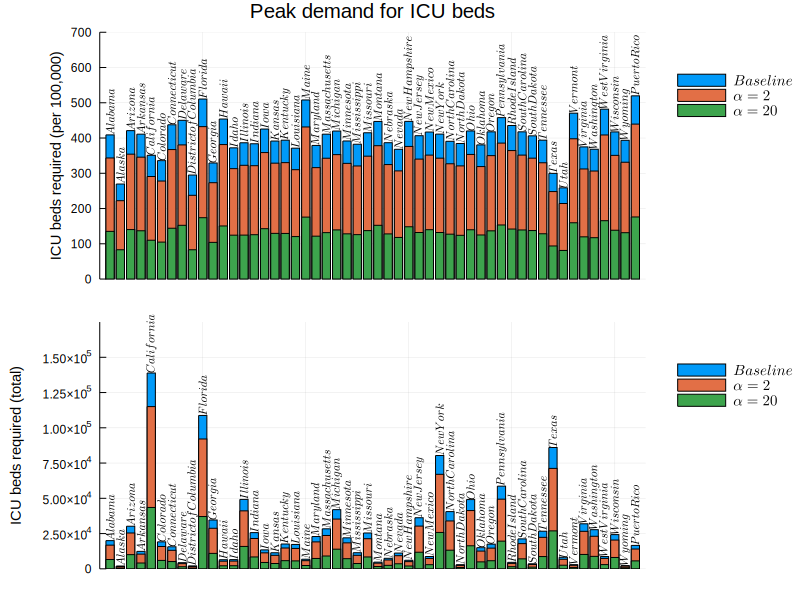

In [34]:
THING = IHC[1:3,2:end]
TITLE = "Peak demand for ICU beds"
YLAB1 = "ICU beds required (per 100,000)"
YLAB2 = "ICU beds required  (total)"
gr()
LL = @layout[a;b]
p1 = bar(THING[1,:] .* 100_000,xlim=(0,53),
    yguidefontsize=10,xaxis=false,ylim=(0,700),
    title = TITLE, label=L"Baseline",
    legend = :outertopright,foreground_color_legend = nothing,background_color_legend=nothing)
bar!(THING[2,:] .* 100_000, label=L"\alpha=2")
bar!(THING[3,:] .* 100_000, label=L"\alpha=20")

font2 = text("").font
font2.rotation = 90
font2.pointsize = 8
for aa = 1:52
annotate!(aa,THING[1,aa] .*100_000+ 0.5, text(latexstring(stateDemog.Column1[aa+1]), font2, :left))
end
ylabel!(YLAB1)

p2 = bar(THING[1,:] .* stateDemog.POPTOTAL[2:end],xlim=(0,53),
    legend = :outertopright,foreground_color_legend = nothing,background_color_legend=nothing,
    yguidefontsize=10,xaxis=false,ylim=(0,17.5*10^4), label=L"Baseline")
bar!(THING[2,:] .* stateDemog.POPTOTAL[2:end],label=L"\alpha=2")
bar!(THING[3,:] .* stateDemog.POPTOTAL[2:end],label=L"\alpha=20")


for aa = 1:52
annotate!(aa,THING[1,aa] .* stateDemog.POPTOTAL[aa+1] +100, text(latexstring(stateDemog.Column1[aa+1]), font2,:left))
end
ylabel!(YLAB2)

plot(p1,p2,layout=LL,size =(800,600))
savefig("ICUdemand_bars_byState_highR0.pdf")
savefig("ICUdemand_bars_byState_highR0.png")
current()

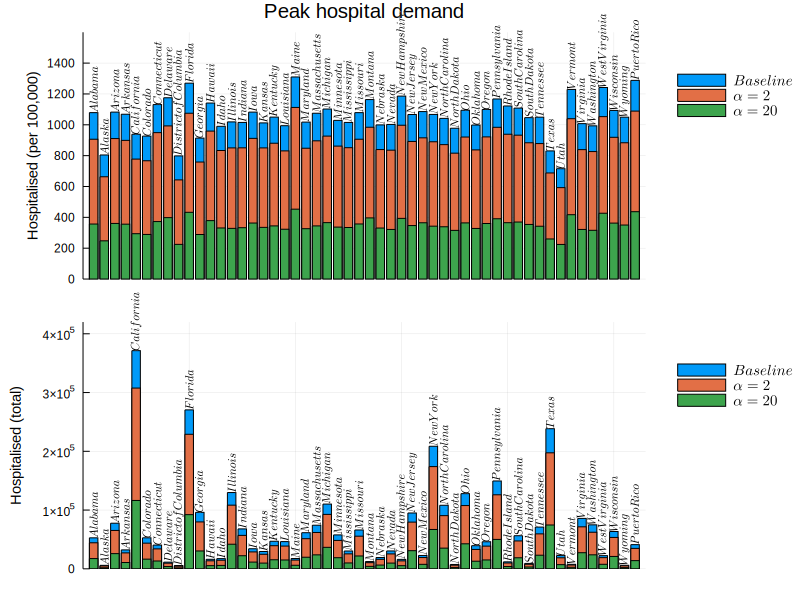

In [35]:
THING = IHS[1:3,2:end] .+ IHC[1:3,2:end]
TITLE = "Peak hospital demand"
YLAB1 = "Hospitalised (per 100,000)"
YLAB2 = "Hospitalised  (total)"
gr()
LL = @layout[a;b]
p1 = bar(THING[1,:] .* 100_000,xlim=(0,53),
    yguidefontsize=10,xaxis=false,ylim=(0,1600),
    title = TITLE, label=L"Baseline",
    legend = :outertopright,foreground_color_legend = nothing,background_color_legend=nothing)
bar!(THING[2,:] .* 100_000, label=L"\alpha=2")
bar!(THING[3,:] .* 100_000, label=L"\alpha=20")

font2 = text("").font
font2.rotation = 90
font2.pointsize = 8
for aa = 1:52
annotate!(aa,THING[1,aa] .*100_000+ 0.5, text(latexstring(stateDemog.Column1[aa+1]), font2, :left))
end
ylabel!(YLAB1)

p2 = bar(THING[1,:] .* stateDemog.POPTOTAL[2:end],xlim=(0,53),
    legend = :outertopright,foreground_color_legend = nothing,background_color_legend=nothing,
    yguidefontsize=10,xaxis=false,ylim=(0,4.2*10^5), label=L"Baseline")
bar!(THING[2,:] .* stateDemog.POPTOTAL[2:end],label=L"\alpha=2")
bar!(THING[3,:] .* stateDemog.POPTOTAL[2:end],label=L"\alpha=20")


for aa = 1:52
annotate!(aa,THING[1,aa] .* stateDemog.POPTOTAL[aa+1] +100, text(latexstring(stateDemog.Column1[aa+1]), font2,:left))
end
ylabel!(YLAB2)

plot(p1,p2,layout=LL,size =(800,600))
savefig("Hospdemand_bars_byState_highR0.pdf")
savefig("Hospdemand_bars_byState_highR0.png")
current()

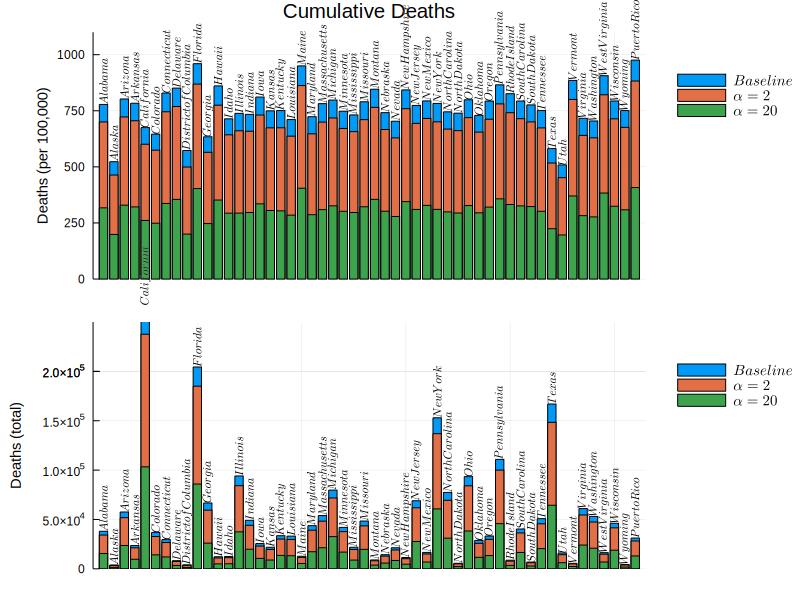

In [36]:
THING = DDD[1:3,2:end]
TITLE = "Cumulative Deaths"
YLAB1 = "Deaths (per 100,000)"
YLAB2 = "Deaths  (total)"
gr()
LL = @layout[a;b]
p1 = bar(THING[1,:] .* 100_000,xlim=(0,53),
    yguidefontsize=10,xaxis=false,ylim=(0,1100),
    title = TITLE, label=L"Baseline",
    legend = :outertopright,foreground_color_legend = nothing,background_color_legend=nothing)
bar!(THING[2,:] .* 100_000, label=L"\alpha=2")
bar!(THING[3,:] .* 100_000, label=L"\alpha=20")

font2 = text("").font
font2.rotation = 90
font2.pointsize = 8
for aa = 1:52
annotate!(aa,THING[1,aa] .*100_000+ 0.5, text(latexstring(stateDemog.Column1[aa+1]), font2, :left))
end
ylabel!(YLAB1)

p2 = bar(THING[1,:] .* stateDemog.POPTOTAL[2:end],xlim=(0,53),
    legend = :outertopright,foreground_color_legend = nothing,background_color_legend=nothing,
    yguidefontsize=10,xaxis=false,ylim=(0,2.5*10^5), label=L"Baseline")
bar!(THING[2,:] .* stateDemog.POPTOTAL[2:end],label=L"\alpha=2")
bar!(THING[3,:] .* stateDemog.POPTOTAL[2:end],label=L"\alpha=20")


for aa = 1:52
annotate!(aa,THING[1,aa] .* stateDemog.POPTOTAL[aa+1] +100, text(latexstring(stateDemog.Column1[aa+1]), font2,:left))
end
ylabel!(YLAB2)

plot(p1,p2,layout=LL,size =(800,600))
savefig("Dead_bars_byState_highR0.pdf")
savefig("Dead_bars_byState_highR0.png")
current()